In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import os
import json

In [2]:
# Find a list of all links leading to each month's articles
def issue_link_finder():
    url = "https://dailytrojan.com/archives/#tab-id-5"

    # Make a request to the website
    response = requests.get(url)
    html_content = response.content

    # Parse the html content using BeautifulSoup
    soup = BeautifulSoup(html_content, "html.parser")

    # Initialize an empty list to store links of each possible subdirectory
    links = []  

    # Find all the links on the website
    li_tags = soup.find_all("li")
    for li in li_tags:
        a = li.find('a')
        link = a.get('href')
        if bool(re.match("^https://dailytrojan\.com/20\d{2}/\d{2}/$", link)):
            links.append(link)
    
    return links

# Find all possible dates (representing all issues) for a given
def get_subpages(url):
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, "html.parser")

    nav_tag = soup.find('nav', class_='pagination')
    if not nav_tag:
        return [url]
    
    max_page = int(nav_tag.find('span', class_='pagination-meta').text.split()[-1])
    subpages = [f"{url}page/{i}/" for i in range(2, max_page+1)]

    return [url] + subpages

def get_article_links_and_dates(url):
    # Fetch the HTML content for the page
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all the article links and dates within the page
    article_links = {}
    article_dates = set()
    for article in soup.find_all('article'):
        link = article.find('a')['href']
        date = link.split('/')[3:6]
        date = '_'.join(date)
        article_dates.add(date)
        if date in article_links:
            article_links[date].append(link)
        else:
            article_links[date] = [link]

    return article_links, article_dates

def get_article_text(url):
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, "html.parser")

    p_tags = soup.find_all('p')
    text = "\n".join([p.get_text() for p in p_tags])

    return text

from make_txt_entry import make_txt_entry

def make_table_entry(school_name="USC",
                     journal_name="Daily Trojan",
                     publication_date=None,
                     raw_data_directory=None,
                     reference_link=None):
    if publication_date is None or raw_data_directory is None or reference_link is None:
        return RuntimeError("Function make_table_entry has invalid arguments.")
    

In [3]:
issue_links = issue_link_finder()

In [4]:
sub_pages = []
for url in issue_links:
    sub_pages.append(get_subpages(url))

In [6]:
print(f"There are {len(issue_links)} months")
sub_page_count = sum([len(sub_page) for sub_page in sub_pages])
print(f"There are {sub_page_count} total sub-pages to traverse")

There are 167 months
There are 3246 total sub-pages to traverse


In [7]:
article_dates = set()
article_pages = {}

for month_sub_pages in sub_pages:
    for sub_page in month_sub_pages:
        try:
            article_links, dates = get_article_links_and_dates(sub_page)
            for date in dates:
                if date in article_pages:
                    article_pages[date].extend(article_links[date])
                else:
                    article_pages[date] = article_links.copy()[date]
                    print(f"Date {date} added.")
            article_dates.update(dates)
        except ConnectionError as ce:
            print(ce, month_sub_pages)

with open("usc_article_pages.json", "w") as outfile:
    json.dump(article_pages, outfile, indent=4)

Date 2023_04_07 added.
Date 2023_04_09 added.
Date 2023_04_06 added.
Date 2023_04_05 added.
Date 2023_04_04 added.
Date 2023_04_03 added.
Date 2023_04_02 added.
Date 2023_03_31 added.
Date 2023_03_30 added.
Date 2023_03_29 added.
Date 2023_03_28 added.
Date 2023_03_27 added.
Date 2023_03_26 added.
Date 2023_03_24 added.
Date 2023_03_23 added.
Date 2023_03_22 added.
Date 2023_03_21 added.
Date 2023_03_20 added.
Date 2023_03_13 added.
Date 2023_03_18 added.
Date 2023_03_11 added.
Date 2023_03_17 added.
Date 2023_03_10 added.
Date 2023_03_15 added.
Date 2023_03_09 added.
Date 2023_03_08 added.
Date 2023_03_07 added.
Date 2023_03_06 added.
Date 2023_03_05 added.
Date 2023_03_03 added.
Date 2023_03_02 added.
Date 2023_03_01 added.
Date 2023_02_28 added.
Date 2023_02_27 added.
Date 2023_02_26 added.
Date 2023_02_24 added.
Date 2023_02_23 added.
Date 2023_02_22 added.
Date 2023_02_17 added.
Date 2023_02_16 added.
Date 2023_02_15 added.
Date 2023_02_13 added.
Date 2023_02_14 added.
Date 2023_0

In [10]:
print(f"There are {len(article_pages)} dates with articles")
total_size = sum([len(article_pages[key]) for key in article_pages])
print(f"There are {total_size} articles to iterate over")

There are 3118 dates with articles
There are 31710 articles to iterate over


In [11]:
school_name = "USC"
for date, articles in article_pages.items():
    file_path = "journal_data/txt/"+school_name.replace(" ","_")+"/"+date+".txt"
    if(os.path.exists(file_path)):
        print(f"Date {date} already added.")
    else:
        article_text = ""
        for article in articles:
            article_text += get_article_text(article) + "\n"
            
        make_txt_entry(school_name="USC", publication_date=date, text=article_text)
        print(f"Date {date} added.")

Date 2023_04_07 already added.
Date 2023_04_09 added.
Date 2023_04_06 already added.
Date 2023_04_05 already added.
Date 2023_04_04 already added.
Date 2023_04_03 already added.
Date 2023_04_02 already added.
Date 2023_03_31 already added.
Date 2023_03_30 already added.
Date 2023_03_29 already added.
Date 2023_03_28 already added.
Date 2023_03_27 already added.
Date 2023_03_26 already added.
Date 2023_03_24 already added.
Date 2023_03_23 already added.
Date 2023_03_22 already added.
Date 2023_03_21 already added.
Date 2023_03_20 already added.
Date 2023_03_13 already added.
Date 2023_03_18 already added.
Date 2023_03_11 already added.
Date 2023_03_17 already added.
Date 2023_03_10 already added.
Date 2023_03_15 already added.
Date 2023_03_09 already added.
Date 2023_03_08 already added.
Date 2023_03_07 already added.
Date 2023_03_06 already added.
Date 2023_03_05 already added.
Date 2023_03_03 already added.
Date 2023_03_02 already added.
Date 2023_03_01 already added.
Date 2023_02_28 

In [4]:
# import importlib
# importlib.reload(queries)

from processors import text_removal_processing

with open("usc_text.txt", "r", encoding="utf8") as f:
    USC_TEXT = f.read()

USC_pipeline = [text_removal_processing(removable_string=USC_TEXT)]

from queries import no_query

from queries import mention_tracker

In [30]:
with open("journal_data/txt/USC/2009_05_27.txt", "r", encoding="utf8") as f:
    example_entry = f.read()
print(f"Before processing there are {len(example_entry)} characters in the entry.")
processed_example_entry = mention_tracker(example_entry, USC_pipeline, no_query)
print(f"After processing there are {len(processed_example_entry)} characters in the entry.")

Before processing there are 96169 characters in the entry.
After processing there are 59464 characters in the entry.


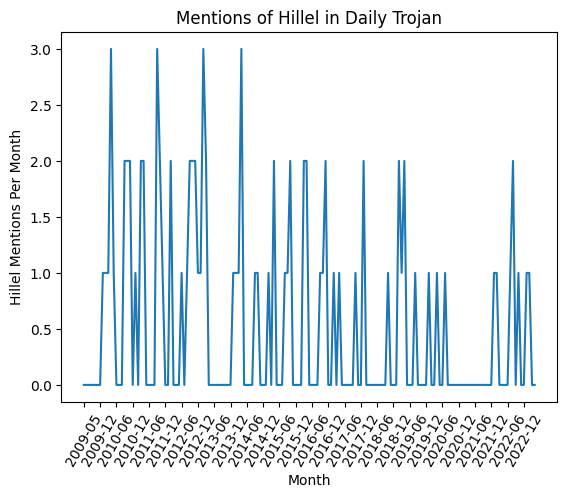

In [19]:
from queries import hillel_counter

import os
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

directory = 'journal_data/txt/USC'

data = []

for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        filepath = os.path.join(directory, filename)
        date_obj = datetime.strptime(filename[:-4], '%Y_%m_%d')
        dates.append(date_obj)

        with open(filepath, 'r', encoding="utf8") as file:
            contents = file.read()
        hillel_count = mention_tracker(contents, USC_pipeline, hillel_counter)
        data.append({'date': date_obj, 'count': 1 if hillel_count > 0 else 0})

df = pd.DataFrame(data)
df['month'] = df['date'].dt.to_period('M')
grouped = df.groupby('month')['count'].sum()

fig, ax = plt.subplots()
ax.plot(grouped.index.strftime('%Y-%m'), grouped.values)
plt.xticks(rotation=60)
ax.set_xlabel('Month')
ax.set_ylabel('Hillel Mentions Per Month')
ax.set_title('Mentions of Hillel in Daily Trojan')

# Show only every third x-axis label
tick_locations = ax.get_xticks()
ax.set_xticks(tick_locations[::6])

plt.show()
plt.savefig('daily_trojan_hillel_mentions.png')